# Download Landcover and QAQC
Must be run after the elevation download.

### Import Statements

In [1]:
import requests
import os
import arcpy
import zipfile
import shutil
import geopandas as gpd
import matplotlib.pyplot as plt
import json

### Download Landcover Data

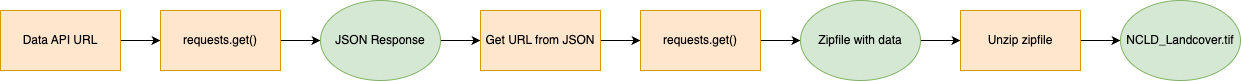

In [45]:
#Path to current directory
cover_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(cover_path)
# Path to data folder
cover_db = cover_path + '\\Commons_Data'
arcpy.env.workspace = cover_db
#Get current directory
direct = os.getcwd()
#Create path for the data
geo_name = os.path.join(direct, "Landcover.zip")

#Request from API
response = requests.get('https://gisdata.mn.gov/api/3/action/package_show?id=biota-landcover-nlcd-mn-2019')

#Check if request was successful
if response.status_code == 200:
    json = response.json()
    #Get URL from API
    geo_url = json['result']['resources'][2]['url']
else:
    print("Failed.")

#Download the data from the URL
geo_result = requests.get(geo_url, stream=True)

#Find folder where the data will be extracted
geo_folder = os.path.join(direct, "Commons_Data")
if not os.path.exists(geo_folder):
    os.mkdir(geo_folder)

#Extract and save content of zipfile
with open(geo_name, 'wb') as file:
    shutil.copyfileobj(geo_result.raw, file)
with zipfile.ZipFile(geo_name, 'r') as zip_cover:
    zip_cover.extractall(geo_folder)

### QAQC

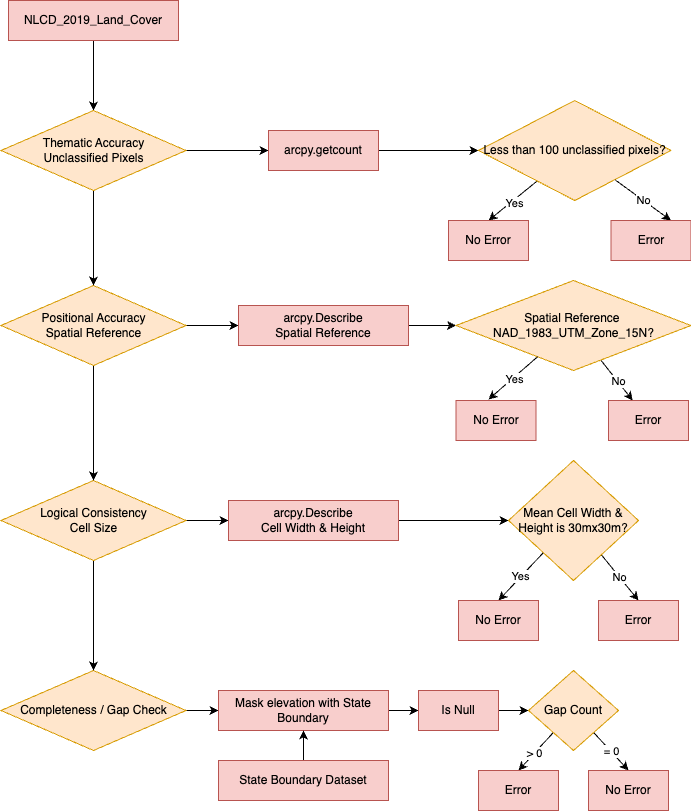

In [59]:
#Thematic Accuracy, Positional Accuracy and Logical Consistency
cover_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(cover_path)
cover_dv = cover_path + '\\Commons_Data'
arcpy.env.workspace = cover_db
cover_file = "NLCD_2019_Land_Cover.tif"

#Create object from land cover
cover_raster = arcpy.Raster(cover_file)
#Count pixels with value 0, unclassified
unclass_count = arcpy.GetCount_management(cover_file).getOutput(0)
# Get spatial reference system
describe = arcpy.Describe(cover_file)
srs = describe.spatialReference
#Get the size of cells
cell_width = describe.meanCellWidth
cell_height = describe.meanCellHeight

if int(unclass_count) < 100:
    print(f"Thematic Accuracy: No Error. {unclass_count} pixels are unclassified.")
else:
    print(f"Thematic Accuracy: Error. {unclass_count} pixels are unclassified.")
#Check if the spatial reference name is "NAD_1983_UTM_Zone_15N"
if srs.name == "NAD_1983_UTM_Zone_15N":
    print("Positional Accuracy: No Error. Matches SRS: {}".format(srs.name))
else:
    print("Positional Accuracy: Error. Data does not match SRS.")
#Check if the cell size is 30 by 30 meters
if cell_width == 30 and cell_height == 30:
    print("Logical Consistency: Cell size of width:{}m and height:{}m is acceptable.".format(cell_width, cell_height))
else:
    print("Logical Consistency: Cell size of width:{}m and height:{}m is not acceptable.".format(cell_width, cell_height))

Thematic Accuracy: No Error. 16 pixels are unclassified.
Positional Accuracy: No Error. Matches SRS: NAD_1983_UTM_Zone_15N
Logical Consistency: Cell size of width: 30.0m and height: 30.0m is acceptable.


In [60]:
#Completeness Check
boundary_path = r"../Commons_Data/bdry_state_of_minnesota.gdb/state_of_minnesota"
#Path to landcover dataset
raster_path = "NLCD_2019_Land_Cover.tif"

#Get raster mask and apply to land cover
raster_with_mask = "raster_mask.tif"
arcpy.env.mask = mask_raster_nodata
arcpy.CopyRaster_management(raster_path, raster_mask)
cover_raster = raster_with_mask

#Check for any gaps in the landcover data
gaps = arcpy.sa.IsNull(cover_raster)
#Count the number of gaps in the landcover data
gaps = arcpy.GetCount_management(gaps)

#Print Out Error or Not
if int(gaps.getOutput(0)) > 0:
    print(f"Completeness: Elevation contains {gaps.getOutput(0)} gaps.")
else:
    print("Completness: Elevation data contains no gaps.")

Completeness: Elevation contains 1 gaps.
